In [8]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

NOTE: SPARK_PREPEND_CLASSES is set, placing locally compiled Spark classes ahead of assembly.
21/11/04 11:29:30 WARN Utils: Your hostname, maropus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.4 instead (on interface en0)
21/11/04 11:29:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/04 11:29:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
import json
from pathlib import Path 
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
len(commits)

10841

In [21]:
import itertools
import re
parse_path = re.compile(f"[a-zA-Z0-9/\-]+/(org\/apache\/spark\/[a-zA-Z0-9/\-]+)\.scala")

corr_map = {}

for _, _, files in commits:
    group = []
    for f in files:
        qs = parse_path.search(f)
        if qs:
            group.append(qs.group(1).replace('/', '.'))
            
    for x, y in filter(lambda p: p[0] != p[1], itertools.product(group, group)):
        if x not in corr_map:
            corr_map[x] = {}
        if y not in corr_map[x]:
            corr_map[x][y] = 0
            
        corr_map[x][y] += 1
        
len(corr_map)

4123

In [22]:
corr_map['org.apache.spark.sql.jdbc.v2.OracleIntegrationSuite']

{'org.apache.spark.sql.jdbc.OracleIntegrationSuite': 7,
 'org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite': 7,
 'org.apache.spark.sql.jdbc.v2.MsSqlServerIntegrationSuite': 6,
 'org.apache.spark.sql.jdbc.v2.MySQLIntegrationSuite': 6,
 'org.apache.spark.sql.jdbc.v2.PostgresIntegrationSuite': 6,
 'org.apache.spark.sql.jdbc.DB2IntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.DB2KrbIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.DockerIntegrationFunSuite': 3,
 'org.apache.spark.sql.jdbc.DockerJDBCIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.DockerKrbJDBCIntegrationSuite': 3,
 'org.apache.spark.sql.jdbc.MariaDBKrbIntegrationSuite': 3,
 'org.apache.spark.sql.jdbc.MsSqlServerIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.MySQLIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.PostgresIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.PostgresKrbIntegrationSuite': 4,
 'org.apache.spark.sql.jdbc.v2.PostgresNamespaceSuite': 3,
 'org.apache.spark.sql.jdbc.v2.V2JDBCNamespaceTest': 3,
 'or

In [33]:
freq_thres = 1

corr_graph = {}
for k, v in corr_map.items():
    corr_graph[k] = list(map(lambda x: x[0], filter(lambda x: x[1] > freq_thres, v.items())))

In [34]:
corr_graph['org.apache.spark.sql.jdbc.v2.OracleIntegrationSuite']

['org.apache.spark.sql.jdbc.OracleIntegrationSuite',
 'org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite',
 'org.apache.spark.sql.jdbc.v2.MsSqlServerIntegrationSuite',
 'org.apache.spark.sql.jdbc.v2.MySQLIntegrationSuite',
 'org.apache.spark.sql.jdbc.v2.PostgresIntegrationSuite',
 'org.apache.spark.sql.jdbc.DB2IntegrationSuite',
 'org.apache.spark.sql.jdbc.DB2KrbIntegrationSuite',
 'org.apache.spark.sql.jdbc.DockerIntegrationFunSuite',
 'org.apache.spark.sql.jdbc.DockerJDBCIntegrationSuite',
 'org.apache.spark.sql.jdbc.DockerKrbJDBCIntegrationSuite',
 'org.apache.spark.sql.jdbc.MariaDBKrbIntegrationSuite',
 'org.apache.spark.sql.jdbc.MsSqlServerIntegrationSuite',
 'org.apache.spark.sql.jdbc.MySQLIntegrationSuite',
 'org.apache.spark.sql.jdbc.PostgresIntegrationSuite',
 'org.apache.spark.sql.jdbc.PostgresKrbIntegrationSuite',
 'org.apache.spark.sql.jdbc.v2.PostgresNamespaceSuite',
 'org.apache.spark.sql.jdbc.v2.V2JDBCNamespaceTest',
 'org.apache.spark.sql.jdbc.v2.V2JDBCTest']

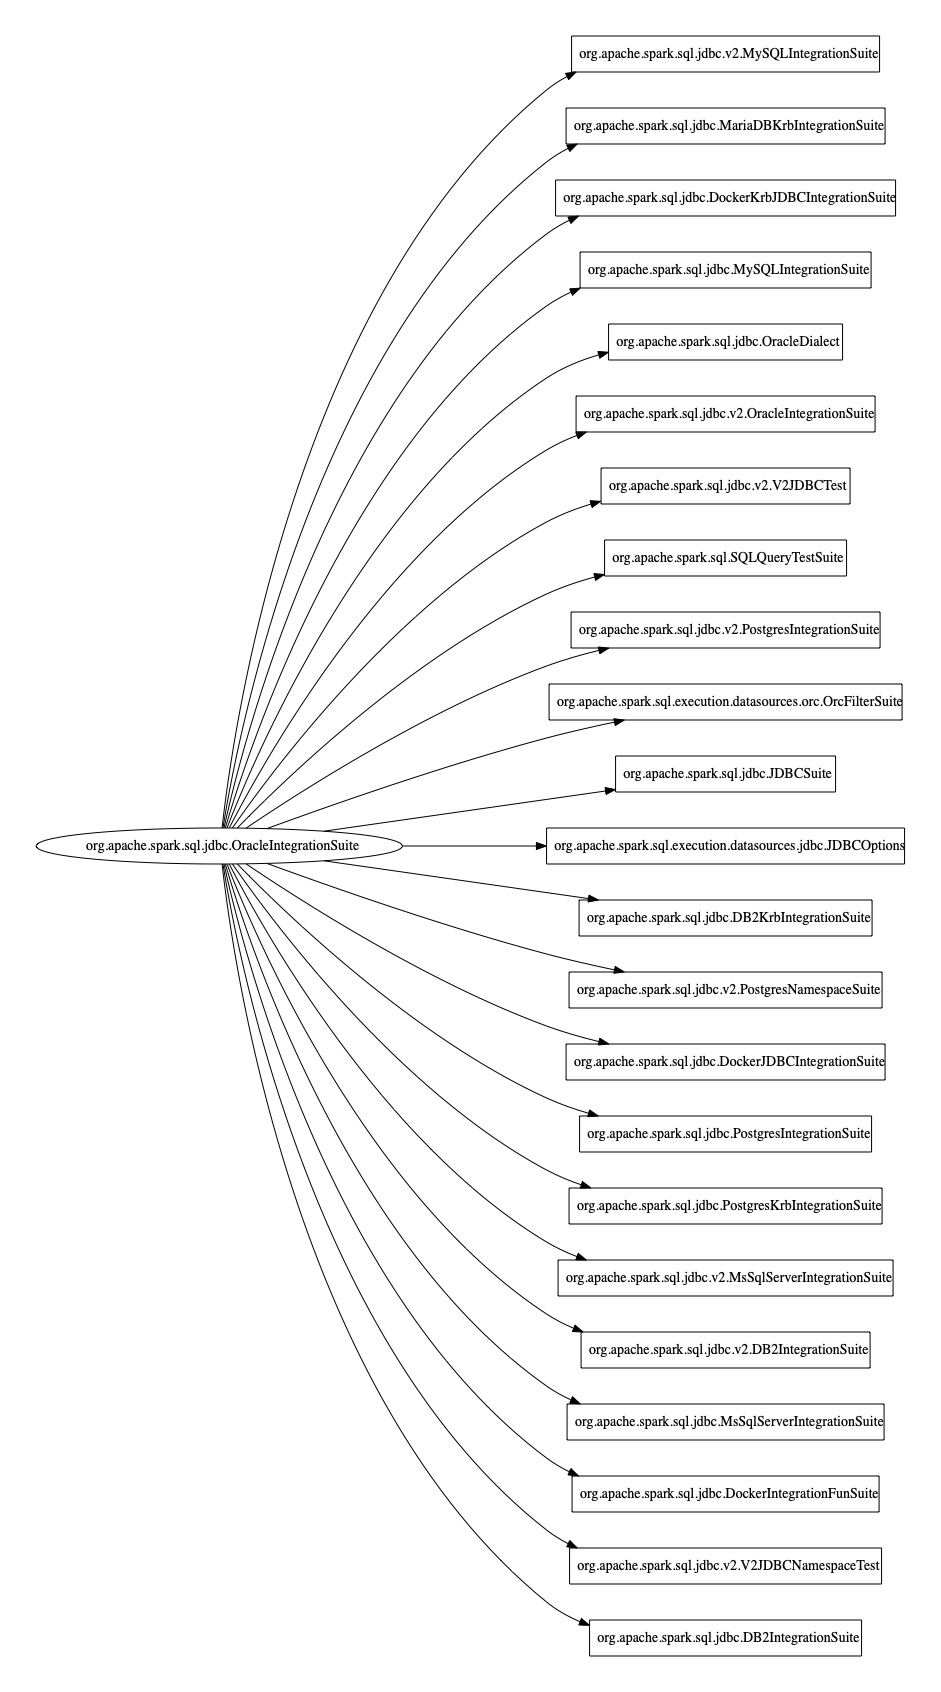

In [77]:
targets = ['org.apache.spark.sql.jdbc.OracleIntegrationSuite']

from ptesting import depgraph

g, nodes = depgraph.select_subgraph(targets, corr_graph, depth=1)
graph_string = depgraph.generate_graph(nodes, targets, g)

import pathlib
import uuid
file_prefix = uuid.uuid4().hex[0:36]
pathlib.Path(f"/tmp/{file_prefix}.dot").write_text(graph_string)
!dot -Tjpg /tmp/{file_prefix}.dot -o /tmp/{file_prefix}.jpg

from IPython.display import SVG, display, Image
display(Image(filename=f'/tmp/{file_prefix}.jpg'))